https://www.kaggle.com/cdeotte/part-2-rapids-tfidfvectorizer-cv-0-700

# setup

In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


HOME = '/data/git/shopee-product-matching'
pdata = f'{HOME}/data/shopee-product-matching'

# metric

In [4]:
# def getMetric(col):
#     def f1score(row):
#         n = len( np.intersect1d(row.target,row[col]) )
#         return 2*n / (len(row.target)+len(row[col]))
#     return f1score

def getf1(x,y):
    n = len(np.intersect1d(x,y))
    return 2*n / (len(x)+len(y))

def getf1s(xs,ys):
    return (getf1(x,y) for x,y in zip(xs,ys))

def meanf1(xs,ys):
    return np.mean(list(getf1s(xs, ys)))

# data and target

In [5]:
df = pd.read_csv(f'{pdata}/train.csv')

pids = df.posting_id.values

display(df.head(2))

grp2ids = df.groupby('label_group').posting_id.agg('unique').to_dict()
targets = df.label_group.map(grp2ids)

targets[:2]

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045


0     [train_129225211, train_2278313361]
1    [train_3386243561, train_3423213080]
Name: label_group, dtype: object

# baselines

## self baseline

In [6]:
preds = df.posting_id.apply(lambda x: [x])
print(preds[0], targets[0])

meanf1(preds,targets)

['train_129225211'] ['train_129225211' 'train_2278313361']


0.4608481791365001

## same hash baseline

In [7]:
hsh2ids = df.groupby('image_phash').posting_id.agg('unique').to_dict()
preds = df.image_phash.map(hsh2ids)
print(preds[0], targets[0])

meanf1(preds,targets)

['train_129225211'] ['train_129225211' 'train_2278313361']


0.5530933399168149

## image sims

In [8]:
sims = np.load(f"{HOME}/data/dev0005/vsims.npy")

sims.shape, sims.min(), sims.max()

((34250, 34250), -0.21813440572237647, 1.0000000000000022)

In [9]:
sims[:3,:10]

array([[ 1.        ,  0.27466938,  0.142582  ,  0.34262326,  0.21371213,
         0.31972283,  0.28817031,  0.24008458,  0.24651348,  0.09452668],
       [ 0.27466938,  1.        ,  0.21357296,  0.17494061,  0.27896646,
         0.12608887,  0.30704449,  0.13560564,  0.22214877,  0.01941465],
       [ 0.142582  ,  0.21357296,  1.        ,  0.1342892 ,  0.21261417,
         0.11804493,  0.17324513,  0.0798133 ,  0.18272873, -0.0207555 ]])

In [10]:
thrsh = 0.9
isclose = sims>=thrsh
preds_idx = (np.where(x)[0] for x in isclose)
preds = [pids[o] for o in preds_idx]
meanf1(preds,targets)

0.6411214285662516

In [11]:
def get_preds_by_thrsh(sims, thrsh):
    isclose = sims>=thrsh
    preds_idx = (np.where(x)[0] for x in isclose)
    return [pids[o] for o in preds_idx]

preds = get_preds_by_thrsh(sims, thrsh=0.9)
meanf1(preds,targets)

0.6411214285662516

In [12]:
thrshes = np.linspace(0.7,1.,num=31)
thrshes

array([0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ,
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91,
       0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

In [13]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(sims, thrsh)
    f1_lst.append(meanf1(preds,targets))
    

100%|██████████| 31/31 [01:32<00:00,  2.99s/it]


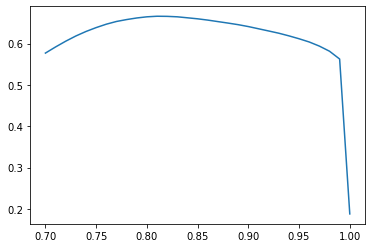

In [14]:
plt.plot(thrshes, f1_lst)

In [15]:
f1_best, thrsh_best = sorted(zip(f1_lst, thrshes), reverse=True)[0]
f1_best, thrsh_best

(0.6661021248340279, 0.8099999999999999)

In [19]:
def find_best(sims, thrshes = np.linspace(0.7,1.,num=31)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(sims, thrsh)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    return f1_best, thrsh_best, preds_best

In [20]:
f1_best, thrsh_best, preds_best = find_best(sims)

100%|██████████| 31/31 [01:33<00:00,  3.01s/it]


In [21]:
f1_best, thrsh_best

(0.6661021248340279, 0.8099999999999999)

## text sims

In [22]:
sims = np.load(f"{HOME}/data/dev0005/tsims.npy")

In [23]:
sims.shape, sims.min(), sims.max()

((34250, 34250), 0.47264884998705725, 1.0000000000000022)

In [24]:
sims[:3,:10]

array([[1.        , 0.76773516, 0.78224733, 0.79733796, 0.75798257,
        0.78678093, 0.72650628, 0.79633748, 0.77628437, 0.84752702],
       [0.76773516, 1.        , 0.81569494, 0.7719416 , 0.77873317,
        0.77790889, 0.77254736, 0.79631262, 0.7891979 , 0.81986963],
       [0.78224733, 0.81569494, 1.        , 0.75700884, 0.79716831,
        0.80797851, 0.75229726, 0.78278977, 0.80849455, 0.85705353]])

In [27]:
thrsh = 0.9
isclose = sims>=thrsh
preds_idx = (np.where(x)[0] for x in isclose)
preds = [pids[o] for o in preds_idx]
meanf1(preds,targets)

0.25259499964312493

In [29]:
preds = get_preds_by_thrsh(sims, thrsh=0.9)
meanf1(preds,targets)

0.25259499964312493

In [35]:
thrshes = np.linspace(0.9,1.,num=11)
thrshes

array([0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

In [38]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(sims, thrsh)
    f1_lst.append(meanf1(preds,targets))

100%|██████████| 11/11 [00:33<00:00,  3.03s/it]


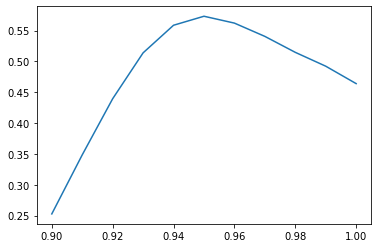

In [39]:
plt.plot(thrshes, f1_lst)

In [40]:
f1_best, thrsh_best = sorted(zip(f1_lst, thrshes), reverse=True)[0]
f1_best, thrsh_best

(0.5732622373044297, 0.95)

In [41]:
f1_best, thrsh_best, preds_best = find_best(sims, np.linspace(0.9,1.,num=11))

100%|██████████| 11/11 [00:33<00:00,  3.05s/it]


In [42]:
f1_best, thrsh_best

(0.5732622373044297, 0.95)

## hash sims

In [43]:
sims = np.load(f"{HOME}/data/dev0011/hsims.npy")

In [52]:
sims.shape, sims.min(), sims.max()

((34250, 34250), 0.01694915254237288, 1.0)

In [53]:
sims[:3,:10]

array([[1.        , 0.02325581, 0.02439024, 0.03225806, 0.03030303,
        0.02857143, 0.03030303, 0.03225806, 0.02564103, 0.02702703],
       [0.02325581, 1.        , 0.03448276, 0.03448276, 0.02857143,
        0.03030303, 0.02702703, 0.04      , 0.03448276, 0.03030303],
       [0.02439024, 0.03448276, 1.        , 0.02857143, 0.02222222,
        0.03703704, 0.02857143, 0.03030303, 0.03448276, 0.03030303]])

In [54]:
thrsh = 0.9
isclose = sims>=thrsh
preds_idx = (np.where(x)[0] for x in isclose)
preds = [pids[o] for o in preds_idx]
meanf1(preds,targets)

0.5530933399168149

In [86]:
preds = get_preds_by_thrsh(sims, thrsh=0.05)
meanf1(preds,targets)

0.06096319561101737

In [89]:
preds = get_preds_by_thrsh(sims, thrsh=0.08)
meanf1(preds,targets)

0.5846935996965729

In [85]:
preds = get_preds_by_thrsh(sims, thrsh=0.1)
meanf1(preds,targets)

0.5956242937941346

In [90]:
preds = get_preds_by_thrsh(sims, thrsh=0.15)
meanf1(preds,targets)

0.5865515822087048

In [91]:
preds = get_preds_by_thrsh(sims, thrsh=0.25)
meanf1(preds,targets)

0.575980978490745

In [92]:
preds = get_preds_by_thrsh(sims, thrsh=0.9)
meanf1(preds,targets)

0.5530933399168149

In [110]:
thrshes = np.linspace(0.07, 0.15,num=21)
thrshes

array([0.07 , 0.074, 0.078, 0.082, 0.086, 0.09 , 0.094, 0.098, 0.102,
       0.106, 0.11 , 0.114, 0.118, 0.122, 0.126, 0.13 , 0.134, 0.138,
       0.142, 0.146, 0.15 ])

In [111]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(sims, thrsh)
    f1_lst.append(meanf1(preds,targets))

100%|██████████| 21/21 [01:03<00:00,  3.02s/it]


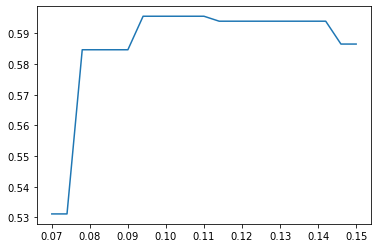

In [112]:
plt.plot(thrshes, f1_lst)

In [113]:
f1_best, thrsh_best = sorted(zip(f1_lst, thrshes), reverse=True)[0]
f1_best, thrsh_best

(0.5956242937941346, 0.11)

In [114]:
f1_best, thrsh_best, preds_best = find_best(sims, np.linspace(0.9,1.,num=11))

100%|██████████| 11/11 [00:32<00:00,  2.98s/it]


In [115]:
f1_best, thrsh_best

(0.5530933399168149, 1.0)

# combine - todo